# `CLOUD.jl` - 1D linear advection with dynamic mode decomposition

In [39]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
results_path = "../results/advection_dgmulti_1D_linear_test/";

Define the physical problem

In [40]:
a = 1.0  # advection velocity
A = 1.0  # amplitude
L = 1.0  # domain length
k = 2*π/L  # wave number
T = 1*L/a  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation(a,λ=1.0);

Set up a quadrature-based DG scheme of degree `p` with `M` elements and periodic boundary conditions

In [41]:
M = 4  # number of elements
p = 3  # degree of discretization

reference_approximation = ReferenceApproximation(
    DGMulti(p), Line(), N_plot=20)
spatial_discretization = SpatialDiscretization(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    (0.0,L), M), reference_approximation)
form = WeakConservationForm()
strategy = Lazy()
solver = Solver(conservation_law, spatial_discretization, form, strategy)

results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, 
     (0.0, T), strategy, results_path, overwrite=true, clear=true);

Set post-processing and plotting options

In [42]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)

tol = 1.0e-12
n_s = prod(get_dof(spatial_discretization,conservation_law))
r = n_s-2
linear_analysis = LinearAnalysis(results_path, conservation_law, spatial_discretization,
    LinearResidual(solver), r=r, tol=tol)
dmd_analysis = DMDAnalysis(results_path, conservation_law, 
    spatial_discretization, r=r, tol=tol)
plotter = Plotter(spatial_discretization, string(results_path,"plots/"));

Run the `OrdinaryDiffEq` solver, taking `n_s` snapshots

In [43]:
dt_scale=0.1
dt = dt_scale*(L/M)/(a*(2*p+1))
u0 = initialize(initial_data, conservation_law, spatial_discretization)
ode_problem = semidiscretize(solver, u0, (0.0, T))
#save_solution(u0, 0.0, results_path, 0)
sol = solve(ode_problem, Tsit5(), adaptive=false, 
    dt=dt, save_everystep=false,
    callback=save_callback(results_path, floor(Int, T/(dt*(n_s-1)))))
#save_solution(last(sol.u), last(sol.t), results_path, "final");
sol.t

17-element Vector{Float64}:
 0.0
 0.0642857142857143
 0.1285714285714286
 0.19285714285714264
 0.25714285714285673
 0.3214285714285708
 0.38571428571428484
 0.4499999999999989
 0.514285714285713
 0.5785714285714271
 0.6428571428571411
 0.7071428571428552
 0.7714285714285692
 0.8357142857142833
 0.8999999999999974
 0.9642857142857114
 1.0

Visualize the solution

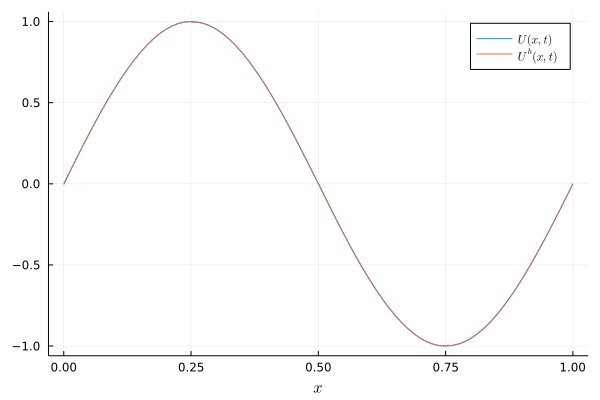

In [44]:
visualize(last(sol.u), plotter, "solution.pdf", exact_solution=initial_data,
    label="U^h(x,t)", label_exact="U(x,t)")

Run analyses

In [45]:
println("L2 error:\n", analyze(error_analysis, last(sol.u), initial_data))
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis)...)
println("Energy (initial/final/diff):\n",analyze(energy_analysis)...)
linear_results = analyze(linear_analysis)
dmd_results = analyze(dmd_analysis);

L2 error:
[0.0009692193775059374]


LoadError: ArgumentError: No file exists at given path: ../results/advection_dgmulti_1D_linear_test/res_final.jld2

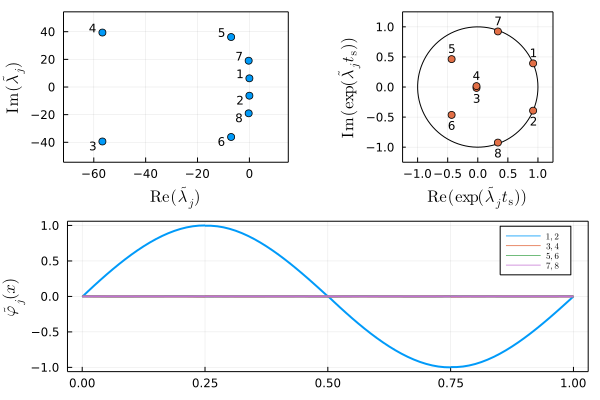

In [46]:
plot_analysis(linear_analysis, linear_results)

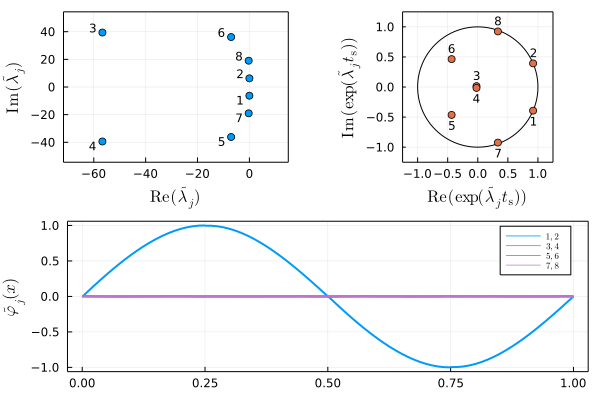

In [47]:
plot_analysis(dmd_analysis, dmd_results)